<a href="https://colab.research.google.com/github/alpayozkan/Dynamic-Inference-with-Neural-Interpreters/blob/main/NerualInterpreters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

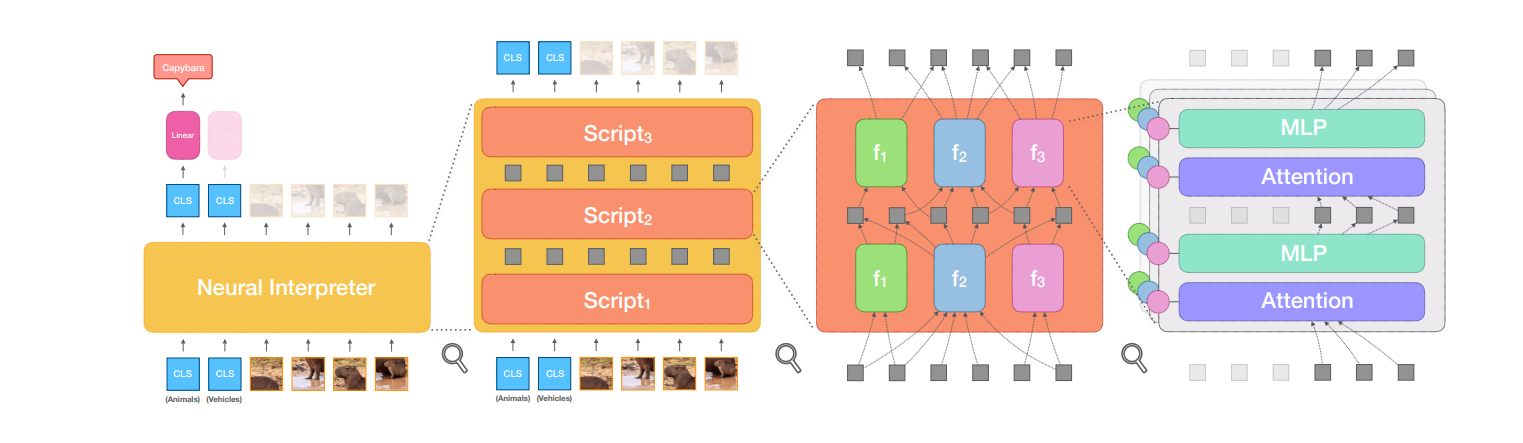

# Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Hyperparameters

In [2]:
# Main Hyperparameters
img_size = 32                           # Dimension of spatial axes of input images
patch_size = 4                          # Patch size
in_channels = 3                         # Dimension of input channels
embed_dim = 256                         # Dimension of embeddings
batch_size = 128                        # Number of batch
epochs = 100                            # Number of epochs
dim_c = 192                             # Dimension of 'code' vector
dim_inter = 192                         # Dimension of intermediate feature vector
ns = 1                                  # Number of 'scripts'
ni = 8                                  # Number of 'function' iterations
nl = 1                                  # Number of LOCs
nf = 5                                  # Number of 'function's
n_cls = 3                               # Number of CLS tokens
n_heads = 4                             # Number of heads per LOC
loc_features = 128                      # Number of features per LOC head

type_inference_depth = 2                # Type Inference MLP depth
type_inference_width = 192              # Type Inference MLP width 
treshold = 1.4                          # Trunctation Parameter
signature_dim = 24                      # Dimension of type_space

# Pretraining Hyperparameters # Dimension of input channels
frozen_function_codes = False           # Required for pretraining
frozen_function_signatures = False      # Required for pretraining

# Optimization Hyperparameters          
beta1 = 0.9                             # Adam Optimizer beta1 parameter
beta2 = 0.999                           # Adam Optimizer beta2 parameter
lr = 1e-8                               # Learning Rate

# Dataloader 

In [3]:
def get_data_loader(datasetname, root, batch_size, transform):
  '''
  Digits dataset is a combination of three related datasets:
      1. SVHN 
      2. MNISTM   -> RESIZE all of them to [32 x 32]
      3. MNIST
  '''
  if datasetname == 'digits':
    # Get the dataset
    svhn = datasets.SVHN(root=root, 
                         split='train',
                         download=True,
                         transform=transform)
    # Get the loader
    loader = DataLoader(
        svhn,
        batch_size = batch_size,
        num_workers = 2,
        pin_memory = True,
        shuffle= True
    )

  return loader

In [4]:
# Parameters for dataset
datasetname = 'digits'
root = 'data/'
batch_size = 128
transform = transforms.Compose([
                  transforms.Resize((32, 32)),
                  transforms.ToTensor()])
loader = get_data_loader(datasetname, root, batch_size, transform)

Using downloaded and verified file: data/train_32x32.mat


In [5]:
data = next(iter(loader))

In [6]:
print('data[0]:', data[0].size())
print('data[1]:', data[1].size())

data[0]: torch.Size([128, 3, 32, 32])
data[1]: torch.Size([128])


In [7]:
def visualize_data(loader):
  # Get a sample of data
  samples = next(iter(loader))[0]
  
  # Determine grid size
  grid_width = 8 
  grid_height = 8
  
  # Create the grid
  image_grid = make_grid(samples[:grid_width*grid_height], nrow=grid_width)
  
  # Visualization arrangement
  plt.rcParams['figure.figsize'] = [grid_height, grid_width]
  plt.imshow(image_grid.permute(1, 2, 0))
  plt.axis('off')
  plt.show()

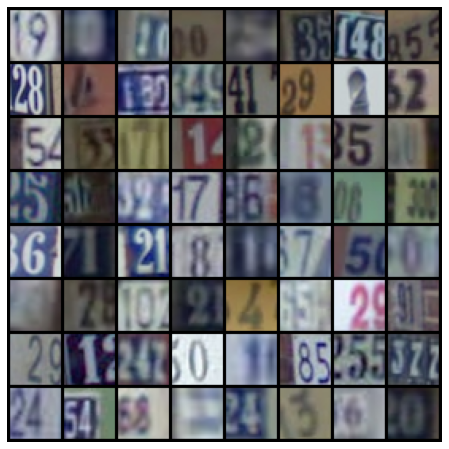

In [8]:
visualize_data(loader)

# Patch Embedding

In [9]:
class PatchEmbedding(nn.Module):
  '''
  Given images are linearly embedded via Patch Embedding in order to get tokens.

  Args:
  -----  
    img_size    [int]: Images are assumed to be square
    patch_size  [int]: Images are divided into patches of size `patch size`
    in_channels [int]: Number of input channels of given images
    embed_dim   [int]: Final embedding dimension

  Attributes:
  -----------
    n_patches   [int]:  Number of total patches at the end
    projection  [Conv]: Patch extractor
  '''

  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.embed_dim = embed_dim
    
    self.n_patches = (img_size // patch_size) ** 2
    self.projection = nn.Conv2d(in_channels = in_channels, 
                                out_channels = embed_dim, 
                                kernel_size = patch_size, 
                                stride = patch_size)
  
  def forward(self, x):
    '''
    Args:
    -----
      x [Tensor(B x C x H x W)]: Input images
    
    Returns:
    --------
      projected [Tensor(B x N x E)] where N stands for n_patches & E stands for embed_dim
    '''
    projected = self.projection(x).flatten(2).transpose(1, 2) 
    return projected

In [10]:
# TEST
img = data[0]
patch_embedding = PatchEmbedding(img_size, 
                                 patch_size, 
                                 in_channels, 
                                 embed_dim)

embeddings = patch_embedding(img)
embeddings.size()

torch.Size([128, 64, 256])

# MLP

In [11]:
class MLP(nn.Module):
  '''
  Type Inference MLP module. 
  
  Args:
  ----
    in_features     [int]: Dimension of input features and output features
    hidden_features [int]: Dimension of intermediate features
    out_features    [int]: Dimension of the signature
    
  Returns:
  -------
    t [Tensor()]: Type vector
  '''
  def __init__(self, in_features, hidden_features, out_features):
    super().__init__()
    self.net = nn.Sequential(
              nn.Linear(in_features, hidden_features),
              nn.GELU(),
              nn.Linear(hidden_features, out_features)
              )

  def forward(self, embeddings):
    '''
    Args:
    ----
      embeddings [Tensor(B x N x E)]: 

    Returns:
    --------
      type_vector [Tensor(B x N x S)] where S stands for signature dimension
    '''
    type_vector = self.net(embeddings)
    return type_vector 

In [12]:
# TEST
mlp = MLP(embed_dim, type_inference_width, signature_dim)
type_vectors = mlp(embeddings)
type_vectors.size()

torch.Size([128, 64, 24])

# TypeInference

In [13]:
from models.basic_layers import TypeMatching

In [14]:
# TEST
s = torch.ones(nf, signature_dim)
type_matching = TypeMatching(embed_dim, type_inference_width, signature_dim, treshold, s)
out = type_matching(embeddings)
out.size() # Expected Size: [B x F x N]

torch.Size([128, 5, 64])

# ModLin

In [15]:
class ModLin(nn.Module):
    '''
    Linear Layer conditioned by `code` vector. 
    
    Args:
    ----
      code  [Tensor(dcond x 1)]: Code vector of a `function`.
      dout  [int]: Dimension of the output of the projection.
      din   [int]: Dimension of the input  of the projection.
      dcond [int]: Dimension of the code vector.
    
    Attributes:
    -----------
      W_c [Tensor(din x dcond)]: Projection matrix of condition vector
      b   [Tensor(dout)]:        bias vector 
      W   [Tensor(dout x din)]:  Projection matrix of conditioned vector

    '''
    def __init__(self, code, dout, din, dcond):
      super().__init__()
      self.c = code
      self.register_parameter('w_c', nn.Parameter(torch.empty(din, dcond)))
      self.register_parameter('b', nn.Parameter(torch.empty(dout)))
      self.register_parameter('W', nn.Parameter(torch.empty(dout, din)))
      self.norm = torch.nn.LayerNorm(din)

    def forward(self, x):
      '''
      Performs linear projection of embeddings in `din` dimensional space onto
      `dout` dimensional space by fusing [conditioning] embeddings [x] with normalized `code`
      vectors.
      '''  
      out = self.norm(torch.matmul(self.w_c, self.c))
      out = x * out
      out = torch.matmul(out, self.W.transpose(0, 1))+self.b
      return out

In [16]:
# TEST
code = torch.ones(dim_c)
dout = 74
din = 256
dcond = dim_c
modlin = ModLin(code, dout, din, dcond)
modlin_out = modlin(embeddings)
modlin_out.size()

torch.Size([128, 64, 74])

In [17]:
from models.basic_layers import ModLin2D
# TEST 2D
code_2d = torch.ones(dim_c, nf)
dout = 64
din = 256
dcond = dim_c

modlin_2d = ModLin2D(code_2d, dout, din, dcond)

print(code_2d.shape)
print(embeddings.shape)
print(embeddings.unsqueeze(1).shape)


torch.Size([192, 5])
torch.Size([128, 64, 256])
torch.Size([128, 1, 64, 256])


# ModMLP

In [18]:
from models.basic_layers import ModAttn

In [19]:
B = 128
ntoken = 64

code_2d = torch.ones(dim_c, nf)
compat_matrix = torch.ones(B, nf, ntoken)

modattn = ModAttn(code_2d, din, dcond, n_heads)
modattn_out = modattn(embeddings, compat_matrix)
modattn_out.shape

torch.Size([128, 5, 64, 256])

In [20]:
t = torch.rand(torch.Size([128, 64, 64]))

In [21]:
t.unsqueeze(1).unsqueeze(1).shape

torch.Size([128, 1, 1, 64, 64])

# White-Box Test

In [22]:
# 1 batch, 2 tokens, 4 dimensional
embed_dim_test = 4
embeddings_test = torch.tensor([[[-20, 50, -4, 16],
                                 [30, -40, -5, -1]]], dtype=torch.float)
embeddings_test.size()

torch.Size([1, 2, 4])

In [23]:
s_test = torch.rand(nf, signature_dim)
type_matching_test = TypeMatching(embed_dim_test, type_inference_width, signature_dim, treshold, s_test)
out_test = type_matching_test(embeddings_test)
out_test.size() # Expected Size: [B x F x N]

torch.Size([1, 5, 2])

In [24]:
out_test

tensor([[[8.9732e-01, 4.9236e-04],
         [0.0000e+00, 7.4671e-01],
         [0.0000e+00, 1.6646e-06],
         [0.0000e+00, 2.1826e-12],
         [1.0236e-01, 1.2260e-04]]], grad_fn=<DivBackward0>)

# Line of COde

In [25]:
from models.basic_layers import LOC

code_matrix = code_2d
funcsign_matrix = torch.rand((nf, signature_dim))
typematch = TypeMatching(din, type_inference_width, signature_dim, treshold, funcsign_matrix)
loc = LOC(code_matrix, din, dcond, n_heads, nl, typematch, attn_prob=0, proj_prob=0)

In [26]:
print(modattn_out.shape)
loc(embeddings).shape

torch.Size([128, 5, 64, 256])
a_hat:  torch.Size([128, 5, 64, 256])
C:  torch.Size([128, 5, 64])
x:  torch.Size([128, 64, 256])
b_hat:  torch.Size([128, 5, 64, 256])
C:  torch.Size([128, 5, 64, 1])
a:  torch.Size([128, 5, 64, 256])


torch.Size([128, 5, 64, 256])

In [27]:
a_hat = torch.rand(torch.Size([128, 5, 64, 256]))
C =  torch.rand(torch.Size([128, 5, 64])).unsqueeze(-1)
tmp = (a_hat*C)

In [28]:
x =   torch.rand(torch.Size([128, 64, 256]))
(x.unsqueeze(1) + tmp).shape

torch.Size([128, 5, 64, 256])

In [29]:
C[0][0][0]

tensor([0.1334])